In [1]:
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Utilizar el conocimiento del experto

En ingeniería de características un lugar importante para utilizar el conocimiento del experto para una aplicación partícular. Mientrs el proposito del ML es en muchos casos evitar tener que crear una conjunto de reglas diseñadas por el experto, que no significa que conocimiento a prior de la aplicación o del dominio deba ser descartado. Frecuentemente, el dominio del experto puede ayudar a identificar las características que son mucho más informatias que la representación inicial de los datos. Imaginar que se trabaja como un agente de viajes y se quiere predecir los precios de vuelos.  Digamos que se tiene un registro de los precios junto con las fechas, aerolineas, locaciones iniciales y destinos. Un modelo de ML puede ser capaz de construir n modelo decente para eso. Algunos de los factores importantes en precios de vuelos, sin embargo, no pueden ser aprendidos. Por ejemplo, los vuelos que usualmente son más caros durante meses pico de vacaciones y cercano a días festivos. Mientras que en fechas de algunos días festivos (como navidad) esta ajustados, y su efecto puede por lo tanto ser aprendido de la fecha, otros pueden depender de la fase del mes (como Hanukkah o Easter) o ser ajustados por las autoridades (como fechas festivas escolares). Estos eventos no pueden ser aprendidos de los datos si cada vuelo es solamente almacenado utiliznado fecha (Grecoriano). Sin embargo, es fácil de añedir características que códifica si un vuelo fue, precedido o seguido de un día festivo escolar o público. De esta forma, el conocimiento a priori acerca de la naturaleza de la tarea puede ser codificado en las características para ayudar a un algoritmo de ML. Agregar características no fuerza al algoritmo de ML utilizarlas, e incluso si la información del día festivo se vuelve no informatico para los precios de los vuelos, aumentar los datos con esta información no daña.

Se revisa un caso utilizando conocimiento del experto (aunque en este caso puede ser más correctametne llamado sentido común). La tarea de predicción de rentas de biciclets en frente de la casa de Andreas.

En NY, Citi Bike opera una red estaciones de renta de bicicletas con un sistema de suscripción. Las estaciones estan sobre la ciudad y proven una forma conveniente de transladarse. Los datos de la renta de bicis fure publicado de forma anónima y ha sido analizada de diferentes formas. La tarea que se quiere resolver es predecir para un tiempo dado y día cuanto gente rentara una bici frente a la casa de Andreas (de esa forma sabrá si alguna bici sobrará para él).

Primero se cargan los datos de agosto del 2015 para esta estación partícular. Se resamplean los daos en intervalode de tres horas para obtener la tendencia principal de cada día.


In [2]:
citibike = mglearn.datasets.load_citibike()

In [3]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0, 0.5, 'Rentals')

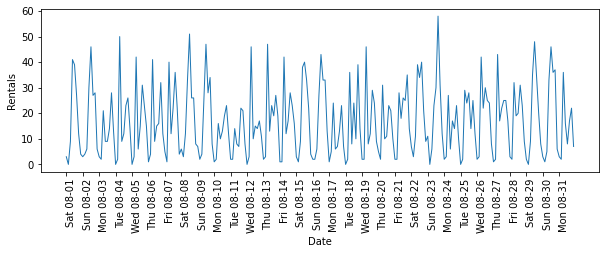

In [4]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

Al observar los datos, se puede distinguir claramente el día y la noche de cada intervalo de 24 horas. El patrón de los fines de semana y entresemana tambien pare un tanto diferente. Cuando se evalua la tarea de predicción de una serie de tiempo como esta, usualmente se quiere aprender del pasado para predecir el futuro. Esto significa que cuando se hace una separción en train y test, se quiere utilizar todos los datos de cierta fecha como el conjunto de entrenamiento y todos los datos del pasado de esa fecha como conjunto de prueba. Esto es como usualmente se utilizaría la series de tiempo de predicción: dado todo lo que se conoce acerca de la renta en el pasado, lo que se hace es pensar que pasara mañana? se utilizan los primero s184 puntos de datos, correspondientes a los primeros 23 días, como conjunto de entrenamiento y los 64 puntos de datos restantes correspondientes a los 8 días restantes, como datos de prueba.

La única característica que se esta utilizando de la tarea de predicciíon son los datos y el tiempo cuando un número partícular de rentas ocurrieron. Por lo tanto, la característica de entrada son los datos y el tiempo (digamos, 2015-08-01 00:00:00) y la salida es número de rentas en as siguientes tres horas (tres en este caso de acuerdo al DataFrame).

Una manera común (sorpresivamente) que las fechas son almacenadas en las computadoras es utilizando tiempo POXIS, el cual es un número de segundos desde Enero de 1970 00:00:00 (también conocido como el principio del tiempo Unix). Como primer intento, se puede utilizar esta única característica como nuestro dato de representación:

In [5]:
# extract the target values (number of rentals)
y = citibike.values
# convert the time to POSIX time using "%s"
X = citibike.index.strftime("%s").astype("int").values.reshape(-1, 1)


In [6]:
# use the first 184 data points for training, and the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:] 
    regressor.fit(X_train, y_train)

    print("Train-set R^2: {:.2f}".format(regressor.score(X_train, y_train))) 
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test))) 
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90, ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Train-set R^2: 0.87
Test-set R^2: -0.04


<Figure size 432x288 with 0 Axes>

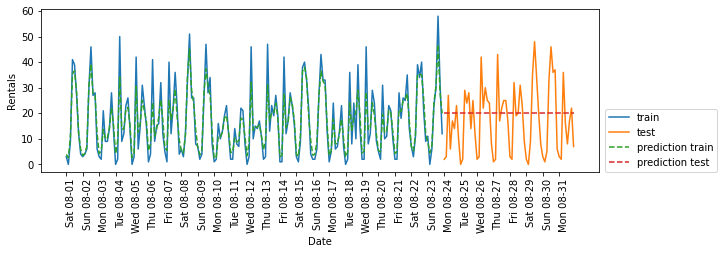

In [7]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0) 
plt.figure()
eval_on_features(X, y, regressor)

La predición en el conjunto de entrenamiento es muy bueno, como es usual para un random forest. Sin embargo, para el conjunto de prueba, una línea constante es predecida. El $R^2$ es -0.03, lo cual significa que no se a aprendido nada. Qué es lo que sucede?

El problema recae en la combinación de nuestras características y random forest. Le valor de la característica de tiempo POXIS para el conjunto de prueba esta fuera del rango de los valores de características en el conjunto de entrenamiento: los puntos en el conjunto de prueba tienen un timestamo que es después que los puntos del conjunto de entrenamiento.Árboles, y por lo tanto random forest, no pueden extrapolar en características del rango fuera del conjunto de entrenamiento. El resultado es que el modelo simplemente predice que el valor objetivo de los puntos cercanos en el conjunto de entrenamiento (el cual es el ultimo tiemppo observado en los datos).

Claramente se puede hacer mejor que esto. Esto es donde el experto en conocimiento entra. A partir de observar las figuras de rentas en los datos de entrenamiento, dos factores parecen ser muy importantes: el tiempo del día y el día de la semana. Así que se agregan estas dos características. No se puede aprender realmente nada de el tiempo POSIX, por lo que se borra la característica. Primero se utilizar la hora del día. Como se muestra en la siguiente figura ahora la predicción tiene el mismo patrón para cada día de la semana.

Train-set R^2: 0.50
Test-set R^2: 0.60


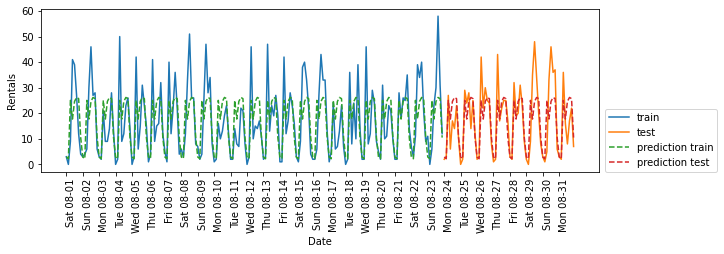

In [8]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

El $R^2$ es realmente mucho mejor, pero las predicciones claramente se pierden el patron de entresemana. Por lo que se agrega el día de la semana 

Train-set R^2: 0.89
Test-set R^2: 0.84


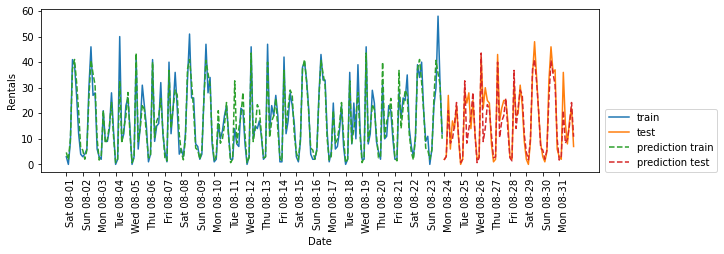

In [9]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                             citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

Ahora se tienen un modelo que **captura el comportamiento periódico** mediante la consideración de el día de la semanan y el tiempo del día. Esto tiene un $R^2$ de 0.84, y muestra muy buen desempeó de predicción.  Que es lo que este modelo probablmente este aprendiendo es el número promedio de reantar para cada combinación del día de la semana y el tiempo del día de los primero 23 días de agosto. Esto no no requiere un modelo complejo como un random forest, asi que se prueba un `LinearRegression`.

Train-set R^2: 0.16
Test-set R^2: 0.13


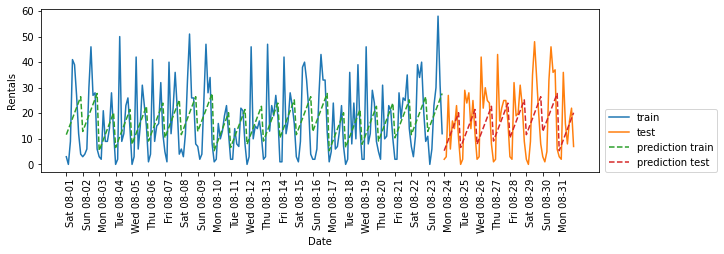

In [10]:
from sklearn.linear_model import LinearRegression 
eval_on_features(X_hour_week, y, LinearRegression())

La regresión lineal funciona mucho peor, y los patrones periódicos lucen raros. La razón de esto es que la códificación de los días de la semana y el día son enteros, lo cual es interpretado como una variable categórica. Por lo tanto el modelo lineal puede solo aprender funciones lineales de el tiempo el día (y aprendió que tarde en el días, hay más rentas). Sin embargo, los patrones son mucho más complejos que eso. Esto se puede captura mediante la interpretación de los enteros como variables categoricas, mediante la transformación de `OneHotEncode`:

Train-set R^2: 0.53
Test-set R^2: 0.62


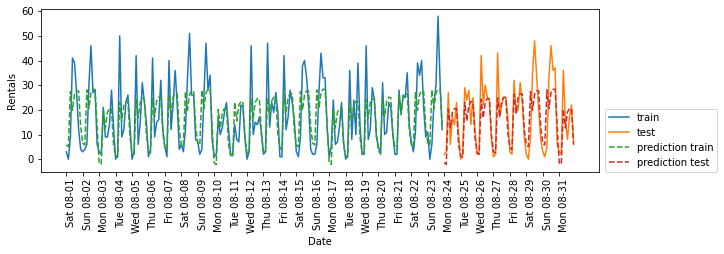

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

eval_on_features(X_hour_week_onehot, y, Ridge())

In [13]:
X_hour_week_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.]])

Esto da una mejor correspondencia de las codificaciones de las características continuas. Ahora el modelo lineal aprende un coeficiente prar cada día de la semana y un coeficiente para cada tiempo del día. Esto significa que el patron del tiempo del día es comporatido sobre todas los días de la seman, 

Utilizando interacción de características, se puede permitir que el modelo aprenda un coeficiente para cada combinación de día y tiempo del día.


Train-set R^2: 0.87
Test-set R^2: 0.85


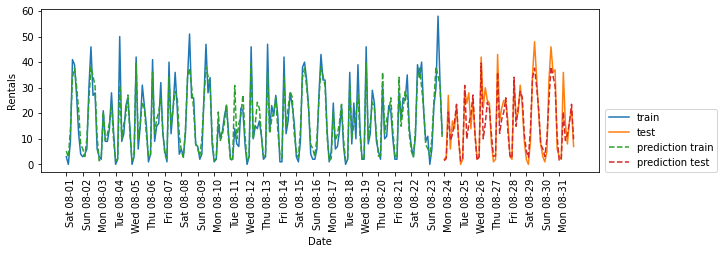

In [14]:
from sklearn.preprocessing import PolynomialFeatures

poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                          include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

Esta transformación finalmente resulta en un modelo que se desempeña de manera similar que el random forest. Un gran beneficio de este modelo es que es mucho más claro que es lo que se aprende: un coeficiente para cad día y tiempo. Se puede simplemente graficar los coeficientes aprendidod mediante el modelo, algo que no podría ser posible para el random forest.

Primero se crean los nombres de características para las características horas y días:

In [15]:
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"] 
features = day + hour

Entonces se nombran todas las interacciones de las características extraídas por `PolynomialFeatures`utilizando el método `get_features_names` y manteniendo solo las características con coeficinetes distintos a cero.

In [16]:
features_poly = poly_transformer.get_feature_names(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

Ahora se pueden visualizar los coeficientes aprendidos por el modelo lineal

Text(0, 0.5, 'Feature')

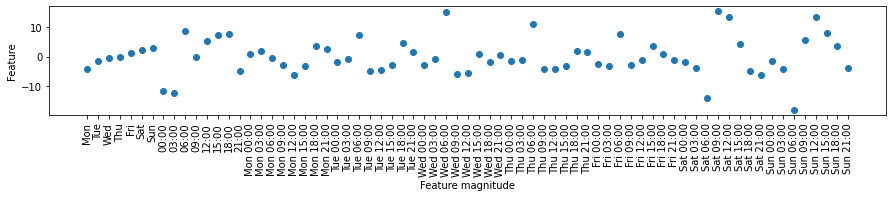

In [17]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("Feature magnitude")
plt.ylabel("Feature")